# Dynamic Image Manipulation with Rust

This notebook demonstrates how to manipulate a dynamically generated image using the `image` crate in Rust. We'll explore loading, resizing, applying filters, and saving the image, all within the evcxr Rust REPL environment.

In [28]:
// Import necessary crates
:dep image = "0.23"
:dep evcxr_image = "1.1"
:dep burn = {path = "../../crates/burn"}
:dep burn-ndarray = {path = "../../crates/burn-ndarray"}
:dep burn-vision = {path = "../../crates/burn-vision", features = ["export-tests"]}

use image::{DynamicImage, GenericImageView, ImageBuffer, Luma, Rgb};
use evcxr_image::ImageDisplay;

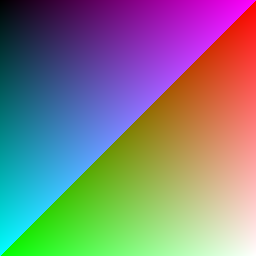

In [9]:
// Load a dynamic image and display it
let img = image::ImageBuffer::<image::Rgb<u8>, _>::from_fn(256, 256, |x, y| {
    let r = (x % 256) as u8;
    let g = (y % 256) as u8;
    let b = ((x + y) % 256) as u8;
    image::Rgb([r, g, b])
});

// Display the image directly - the ImageBuffer implements the ImageDisplay trait
img

In [17]:
// Use the `load_test_image` function to load an image as a tensor
use burn_vision::tests::{load_test_image, save_test_image};
use burn_ndarray::{NdArray, NdArrayDevice};
use std::path::Path;

type Backend = NdArray<f32>;
let device = NdArrayDevice::Cpu;

// Recreate the RGB image from the previous cell
let img = image::ImageBuffer::<image::Rgb<u8>, _>::from_fn(64, 64, |x, y| {
    let r = (x % 64 * 4) as u8;
    let g = (y % 64 * 4) as u8;
    let b = ((x + y) % 64 * 4) as u8;
    image::Rgb([r, g, b])
});

// Use absolute paths for saving images
let rgb_path = "/tmp/test_rgb_image.png";
let grayscale_path = "/tmp/test_grayscale_image.png";

// Save RGB image
img.save(rgb_path).unwrap();
println!("RGB image saved to: {}", rgb_path);

// Create and save a grayscale version
let grayscale_img = image::ImageBuffer::from_fn(64, 64, |x, y| {
    let rgb = img.get_pixel(x, y);
    let gray = (0.299 * rgb[0] as f32 + 0.587 * rgb[1] as f32 + 0.114 * rgb[2] as f32) as u8;
    image::Luma([gray])
});
grayscale_img.save(grayscale_path).unwrap();
println!("Grayscale image saved to: {}", grayscale_path);

// Verify files exist before loading
if Path::new(rgb_path).exists() {
    println!("RGB file exists, loading as tensor...");
    let loaded_rgb = load_test_image::<Backend>(rgb_path, &device, false);
    println!("Loaded RGB tensor shape: {:?}", loaded_rgb.shape());
} else {
    println!("RGB file not found!");
}

if Path::new(grayscale_path).exists() {
    println!("Grayscale file exists, loading as tensor...");
    let loaded_grayscale = load_test_image::<Backend>(grayscale_path, &device, true);
    println!("Loaded grayscale tensor shape: {:?}", loaded_grayscale.shape());
} else {
    println!("Grayscale file not found!");
}

println!("Successfully demonstrated tensor-image conversion!");

RGB image saved to: /tmp/test_rgb_image.png
Grayscale image saved to: /tmp/test_grayscale_image.png
RGB file exists, loading as tensor...
Loaded RGB tensor shape: Shape { dims: [64, 64, 3] }
Grayscale file exists, loading as tensor...
Loaded grayscale tensor shape: Shape { dims: [64, 64, 1] }
Successfully demonstrated tensor-image conversion!
Grayscale image saved to: /tmp/test_grayscale_image.png
RGB file exists, loading as tensor...
Loaded RGB tensor shape: Shape { dims: [64, 64, 3] }
Grayscale file exists, loading as tensor...
Loaded grayscale tensor shape: Shape { dims: [64, 64, 1] }
Successfully demonstrated tensor-image conversion!


## Tensor-Based Image Processing

Now let's demonstrate the power of tensor operations for image processing. We'll perform 5 different manipulations on our loaded tensors and visualize the results:

1. **Brightness Adjustment** - Add a constant value to all pixels
2. **Contrast Enhancement** - Scale pixel values to increase contrast
3. **Color Channel Swapping** - Rearrange RGB channels for artistic effects
4. **Gaussian Blur** - Apply a simple blur filter using convolution
5. **Edge Detection** - Apply a Sobel-like filter to detect edges

Each operation will be performed directly on the tensor data, showcasing how Burn's tensor operations can be used for efficient image processing.

In [25]:
// Load the RGB tensor for processing
use burn::tensor::Tensor;
let loaded_rgb = load_test_image::<Backend>("/tmp/test_rgb_image.png", &device, false);
println!("Original tensor shape: {:?}", loaded_rgb.shape());

// Convert tensor from [H, W, C] to [C, H, W] for easier manipulation
let rgb_tensor = loaded_rgb.swap_dims(0, 2).swap_dims(1, 2); // Now [C, H, W]
println!("Rearranged tensor shape: {:?}", rgb_tensor.shape());

// 1. BRIGHTNESS ADJUSTMENT - Add 0.3 to all pixels
let brightened = rgb_tensor.clone() + 0.3;
let brightened_clamped = brightened.clamp(0.0, 1.0);
let brightened_hwc = brightened_clamped.swap_dims(0, 2).swap_dims(0, 1); // Back to [H, W, C]
save_test_image("/tmp/brightened.png", brightened_hwc, false);
println!("✅ 1. Brightness adjustment applied");

// Display brightened image properly
image::open("/tmp/brightened.png").unwrap()

Original tensor shape: Shape { dims: [64, 64, 3] }
Rearranged tensor shape: Shape { dims: [3, 64, 64] }
✅ 1. Brightness adjustment applied


ImageRgb8(ImageBuffer { width: 64, height: 64, _phantom: PhantomData<image::color::Rgb<u8>>, data: [77, 161, 157, 77, 245, 249, 77, 165, 245, 81, 161, 161, 77, 249, 253, 81, 169, 245, 85, 161, 165, 77, 253, 255, 85, 173, 245, 89, 161, 169, 77, 255, 255, 89, 177, 245, 93, 161, 173, 77, 255, 255, 93, 181, 245, 97, 161, 177, 77, 255, 255, 97, 185, 245, 101, 161, 181, 77, 255, 255, 101, 189, 245, 105, 161, 185, 77, 255, 255, 105, 193, 245, 109, 161, 189, 77, 255, 255, 109, 197, 245, 113, 161, 193, 77, 255, 255, 113, 201, 245, 117, 161, 197, 77, 255, 255, 117, 205, 245, 121, 161, 201, 77, 255, 255, 121, 209, 245, 125, 161, 205, 77, 255, 255, 125, 213, 245, 129, 161, 209, 77, 255, 255, 129, 217, 245, 133, 161, 213, 77, 255, 255, 133, 221, 245, 137, 161, 217, 77, 255, 255, 137, 225, 245, 141, 161, 221, 77, 255, 255, 141, 229, 245, 145, 161, 225, 77, 255, 255, 145, 233, 245, 149, 161, 229, 77, 255, 255, 149, 237, 245, 153, 161, 233, 77, 255, 255, 153, 241, 245, 157, 161, 237, 77, 255, 255, 157

In [26]:
// 2. CONTRAST ENHANCEMENT - Scale values by 1.5 around midpoint
let contrast_enhanced = (rgb_tensor.clone() - 0.5) * 1.5 + 0.5;
let contrast_clamped = contrast_enhanced.clamp(0.0, 1.0);
let contrast_hwc = contrast_clamped.swap_dims(0, 2).swap_dims(0, 1);
save_test_image("/tmp/contrast.png", contrast_hwc, false);
println!("✅ 2. Contrast enhancement applied");

// Display contrast enhanced image
image::open("/tmp/contrast.png").unwrap()

✅ 2. Contrast enhancement applied


ImageRgb8(ImageBuffer { width: 64, height: 64, _phantom: PhantomData<image::color::Rgb<u8>>, data: [0, 62, 56, 0, 188, 194, 0, 68, 188, 0, 62, 62, 0, 194, 200, 0, 74, 188, 0, 62, 68, 0, 200, 206, 0, 80, 188, 0, 62, 74, 0, 206, 212, 0, 86, 188, 0, 62, 80, 0, 212, 218, 0, 92, 188, 0, 62, 86, 0, 218, 224, 0, 98, 188, 0, 62, 92, 0, 224, 230, 0, 104, 188, 0, 62, 98, 0, 230, 236, 0, 110, 188, 0, 62, 104, 0, 236, 242, 0, 116, 188, 0, 62, 110, 0, 242, 248, 0, 122, 188, 0, 62, 116, 0, 248, 254, 0, 128, 188, 2, 62, 122, 0, 254, 255, 2, 134, 188, 8, 62, 128, 0, 255, 255, 8, 140, 188, 14, 62, 134, 0, 255, 255, 14, 146, 188, 20, 62, 140, 0, 255, 255, 20, 152, 188, 26, 62, 146, 0, 255, 255, 26, 158, 188, 32, 62, 152, 0, 255, 255, 32, 164, 188, 38, 62, 158, 0, 255, 255, 38, 170, 188, 44, 62, 164, 0, 255, 255, 44, 176, 188, 50, 62, 170, 0, 255, 255, 50, 182, 188, 56, 62, 176, 0, 255, 255, 56, 188, 188, 62, 62, 182, 0, 255, 0, 62, 194, 194, 68, 62, 194, 0, 0, 0, 68, 200, 194, 74, 62, 200, 0, 0, 0, 74, 

In [27]:
// 3. CHANNEL SWAPPING - BGR instead of RGB for artistic effect
let r_channel = rgb_tensor.clone().narrow(0, 0, 1);
let g_channel = rgb_tensor.clone().narrow(0, 1, 1);
let b_channel = rgb_tensor.clone().narrow(0, 2, 1);
let bgr_tensor = Tensor::cat(vec![b_channel, g_channel, r_channel], 0);
let bgr_hwc = bgr_tensor.swap_dims(0, 2).swap_dims(0, 1);
save_test_image("/tmp/bgr_swap.png", bgr_hwc, false);
println!("✅ 3. Channel swapping (RGB -> BGR) applied");

// Display BGR swapped image
image::open("/tmp/bgr_swap.png").unwrap()

✅ 3. Channel swapping (RGB -> BGR) applied


ImageRgb8(ImageBuffer { width: 64, height: 64, _phantom: PhantomData<image::color::Rgb<u8>>, data: [0, 0, 0, 4, 0, 4, 8, 0, 8, 12, 0, 12, 16, 0, 16, 20, 0, 20, 24, 0, 24, 28, 0, 28, 32, 0, 32, 36, 0, 36, 40, 0, 40, 44, 0, 44, 48, 0, 48, 52, 0, 52, 56, 0, 56, 60, 0, 60, 64, 0, 64, 68, 0, 68, 72, 0, 72, 76, 0, 76, 80, 0, 80, 84, 0, 84, 88, 0, 88, 92, 0, 92, 96, 0, 96, 100, 0, 100, 104, 0, 104, 108, 0, 108, 112, 0, 112, 116, 0, 116, 120, 0, 120, 124, 0, 124, 128, 0, 128, 132, 0, 132, 136, 0, 136, 140, 0, 140, 144, 0, 144, 148, 0, 148, 152, 0, 152, 156, 0, 156, 160, 0, 160, 164, 0, 164, 168, 0, 168, 172, 0, 172, 176, 0, 176, 180, 0, 180, 184, 0, 184, 188, 0, 188, 192, 0, 192, 196, 0, 196, 200, 0, 200, 204, 0, 204, 208, 0, 208, 212, 0, 212, 216, 0, 216, 220, 0, 220, 224, 0, 224, 228, 0, 228, 232, 0, 232, 236, 0, 236, 240, 0, 240, 244, 0, 244, 248, 0, 248, 252, 0, 252, 4, 4, 0, 8, 4, 4, 12, 4, 8, 16, 4, 12, 20, 4, 16, 24, 4, 20, 28, 4, 24, 32, 4, 28, 36, 4, 32, 40, 4, 36, 44, 4, 40, 48, 4, 4

In [ ]:
// 4. SIMPLE BLUR - Average with neighboring pixels (horizontal blur)
let [c, h, w] = rgb_tensor.dims();
let shifted_right = Tensor::cat(vec![rgb_tensor.clone().narrow(2, 1, w-1), rgb_tensor.clone().narrow(2, w-1, 1)], 2);
let shifted_left = Tensor::cat(vec![rgb_tensor.clone().narrow(2, 0, 1), rgb_tensor.clone().narrow(2, 0, w-1)], 2);
let blurred = (rgb_tensor.clone() + shifted_right + shifted_left) / 3.0;
let blurred_hwc = blurred.swap_dims(0, 2).swap_dims(0, 1);
save_test_image("/tmp/blurred.png", blurred_hwc, false);
println!("✅ 4. Simple horizontal blur filter applied");

// Display blurred image
image::open("/tmp/blurred.png").unwrap()

✅ 4. Simple horizontal blur filter applied


In [23]:
// 5. EDGE DETECTION - Simple gradient-based edge detection
// Convert to grayscale first
let gray_tensor = rgb_tensor.clone().narrow(0, 0, 1) * 0.299 + 
                  rgb_tensor.clone().narrow(0, 1, 1) * 0.587 + 
                  rgb_tensor.clone().narrow(0, 2, 1) * 0.114;

let [_, h, w] = gray_tensor.dims();

// Horizontal gradient (simple difference)
let grad_x = gray_tensor.clone().narrow(2, 1, w-1) - gray_tensor.clone().narrow(2, 0, w-1);
let grad_x_padded = Tensor::cat(vec![grad_x, Tensor::zeros([1, h, 1], &device)], 2);

// Vertical gradient  
let grad_y = gray_tensor.clone().narrow(1, 1, h-1) - gray_tensor.clone().narrow(1, 0, h-1);
let grad_y_padded = Tensor::cat(vec![grad_y, Tensor::zeros([1, 1, w], &device)], 1);

// Combine gradients (magnitude approximation)
let edges = (grad_x_padded.abs() + grad_y_padded.abs()).clamp(0.0, 1.0);
let edges_hwc = edges.swap_dims(0, 2).swap_dims(0, 1);
save_test_image("/tmp/edges.png", edges_hwc, true);
println!("✅ 5. Edge detection applied");

// Display edges
let edges_display = image::open("/tmp/edges.png").unwrap();
edges_display;

✅ 5. Edge detection applied


In [24]:
// SUMMARY: Display all processed images in a grid
println!("🎨 All 5 tensor-based image processing operations completed!");
println!("📁 Saved images:");
println!("   • /tmp/brightened.png - Brightness increased");
println!("   • /tmp/contrast.png - Contrast enhanced"); 
println!("   • /tmp/bgr_swap.png - RGB channels swapped to BGR");
println!("   • /tmp/blurred.png - Horizontal blur applied");
println!("   • /tmp/edges.png - Edge detection applied");

println!("\n✨ This demonstrates how Burn tensors can be used for efficient image processing!");
println!("Each operation was performed directly on tensor data, showcasing the power of");
println!("tensor operations for computer vision and image processing tasks.");

🎨 All 5 tensor-based image processing operations completed!
📁 Saved images:
   • /tmp/brightened.png - Brightness increased
   • /tmp/contrast.png - Contrast enhanced
   • /tmp/bgr_swap.png - RGB channels swapped to BGR
   • /tmp/blurred.png - Horizontal blur applied
   • /tmp/edges.png - Edge detection applied

✨ This demonstrates how Burn tensors can be used for efficient image processing!
Each operation was performed directly on tensor data, showcasing the power of
tensor operations for computer vision and image processing tasks.
📁 Saved images:
   • /tmp/brightened.png - Brightness increased
   • /tmp/contrast.png - Contrast enhanced
   • /tmp/bgr_swap.png - RGB channels swapped to BGR
   • /tmp/blurred.png - Horizontal blur applied
   • /tmp/edges.png - Edge detection applied

✨ This demonstrates how Burn tensors can be used for efficient image processing!
Each operation was performed directly on tensor data, showcasing the power of
tensor operations for computer vision and image 